In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from prophet import Prophet
from neuralprophet import NeuralProphet
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import time
import numpy as np

In [2]:
m = NeuralProphet(n_changepoints=10,
                  n_lags=10,
                  changepoints_range=0.75,
                  learning_rate = 1.1)

df = pd.read_csv('../forecasting/historical_data/cable_retention_monthly.csv', parse_dates=['ds'])
# df.loc[(df['ds'] > '2020-02-01') & (df['ds'] < '2020-12-01'), 'y'] = None
# create a test holdout set:
df_train_val, df_test = m.split_df(df=df, freq="MS", valid_p=0.2)
# create a validation holdout set:
df_train, df_val = m.split_df(df=df_train_val, freq="MS", valid_p=0.2)

In [3]:
# fit a model on training data and evaluate on validation set.
metrics_train1 = m.fit(df=df_train, freq="MS")
metrics_val = m.test(df=df_val)


In [4]:
# refit model on training and validation data and evaluate on test set.
m = NeuralProphet(n_changepoints=10,
                  n_lags=10,
                  changepoints_range=0.75,
                  learning_rate = 1.1)
metrics_train2 = m.fit(df=df_train_val, freq="MS")
metrics_test = m.test(df=df_test)

In [5]:
metrics_train1["split"]  = "train1"
metrics_train2["split"]  = "train2"
metrics_val["split"] = "validate"
metrics_test["split"] = "test"
metrics_train1.tail(1).append([metrics_train2.tail(1), metrics_val, metrics_test]).drop(columns=['RegLoss'])

,SmoothL1Loss,MAE,RMSE,split
973,0.000517,241.844800,318.099844,train1
830,0.000795,339.376737,411.164753,train2
0,0.007118,952.078491,1221.302002,validate
0,0.014201,1552.088989,1759.261230,test


In [6]:
METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
params = {'n_changepoints': 10, 'n_lags': 10, 'changepoints_range': 0.75, 'learning_rate': 1.1}

df = pd.read_csv('../forecasting/historical_data/cable_retention_monthly.csv', parse_dates=['ds'])
folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="MS", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

In [7]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS)

for df_train, df_test in folds:
    m = NeuralProphet(**params)
    train = m.fit(df=df_train, freq="MS")
    test = m.test(df=df_test)
    metrics_train = metrics_train.append(train[METRICS].iloc[-1])
    metrics_test = metrics_test.append(test[METRICS].iloc[-1])

In [8]:
metrics_test.describe()

,SmoothL1Loss,MAE,RMSE
count,5.000000,5.000000,5.000000
unique,5.000000,5.000000,5.000000
top,0.041558,1211.873169,1473.501099
freq,1.000000,1.000000,1.000000


In [9]:
metrics_val.describe()

,SmoothL1Loss,MAE,RMSE
count,1.000000,1.000000,1.000000
mean,0.007118,952.078491,1221.302002
std,NaN,NaN,NaN
min,0.007118,952.078491,1221.302002
25%,0.007118,952.078491,1221.302002
50%,0.007118,952.078491,1221.302002
75%,0.007118,952.078491,1221.302002
max,0.007118,952.078491,1221.302002


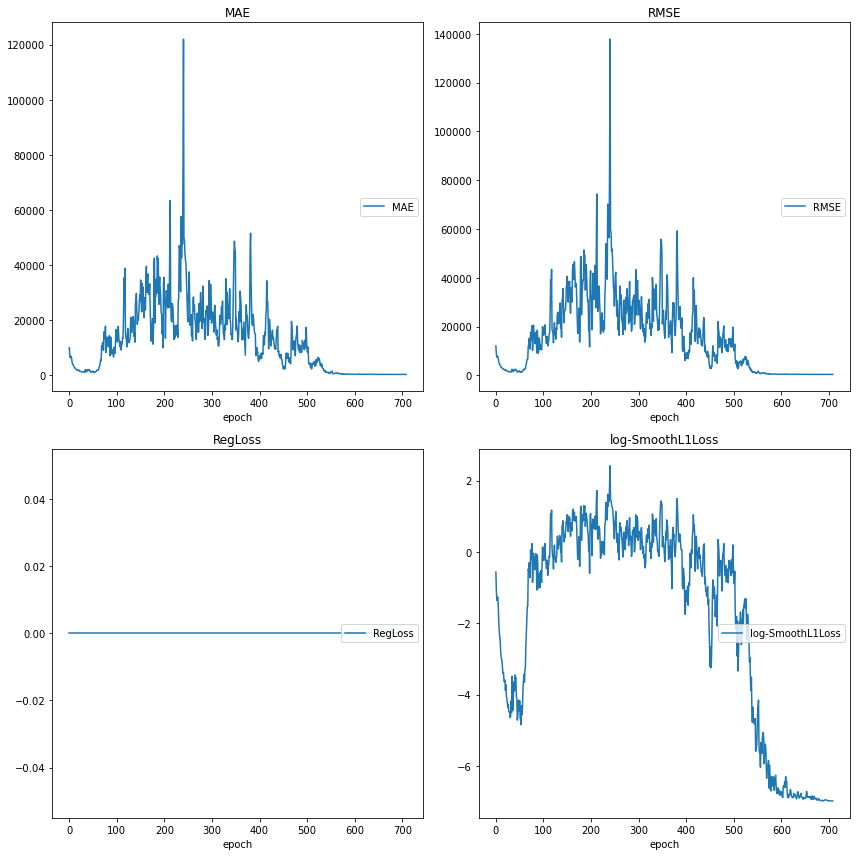

MAE
	MAE              	 (min:  345.001, max: 121964.946, cur:  351.437)
RMSE
	RMSE             	 (min:  430.786, max: 137805.528, cur:  447.616)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -6.984, max:    2.415, cur:   -6.980)


In [10]:
m = NeuralProphet(n_changepoints=10,
                  n_lags=10,
                  changepoints_range=0.75,
                  learning_rate = 1.1
                 )
metrics = m.fit(df,progress='plot-all')

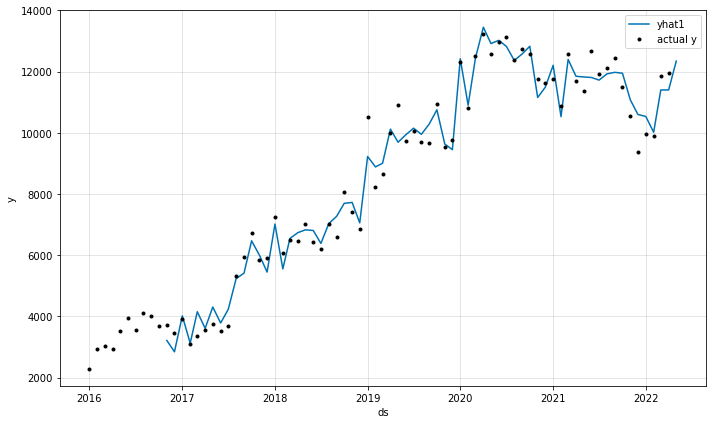

In [11]:
future = m.make_future_dataframe(df, n_historic_predictions=True)
forecast = m.predict(future)
fig = m.plot(forecast)

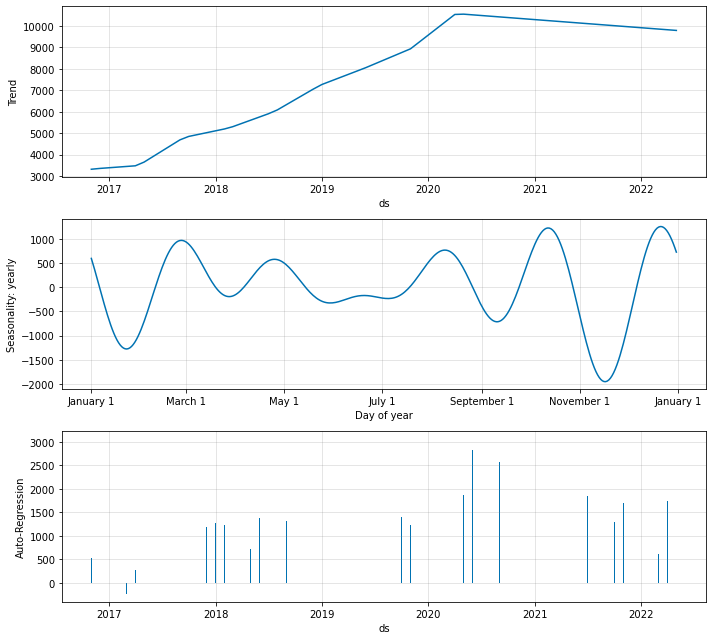

In [12]:
fig_comp = m.plot_components(forecast)


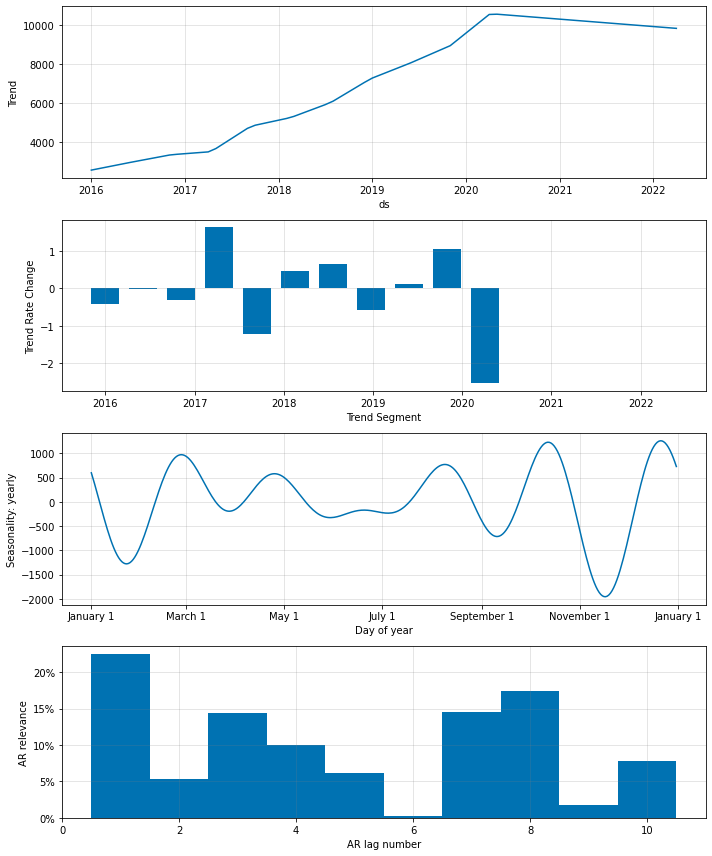

In [13]:
fig_param = m.plot_parameters()

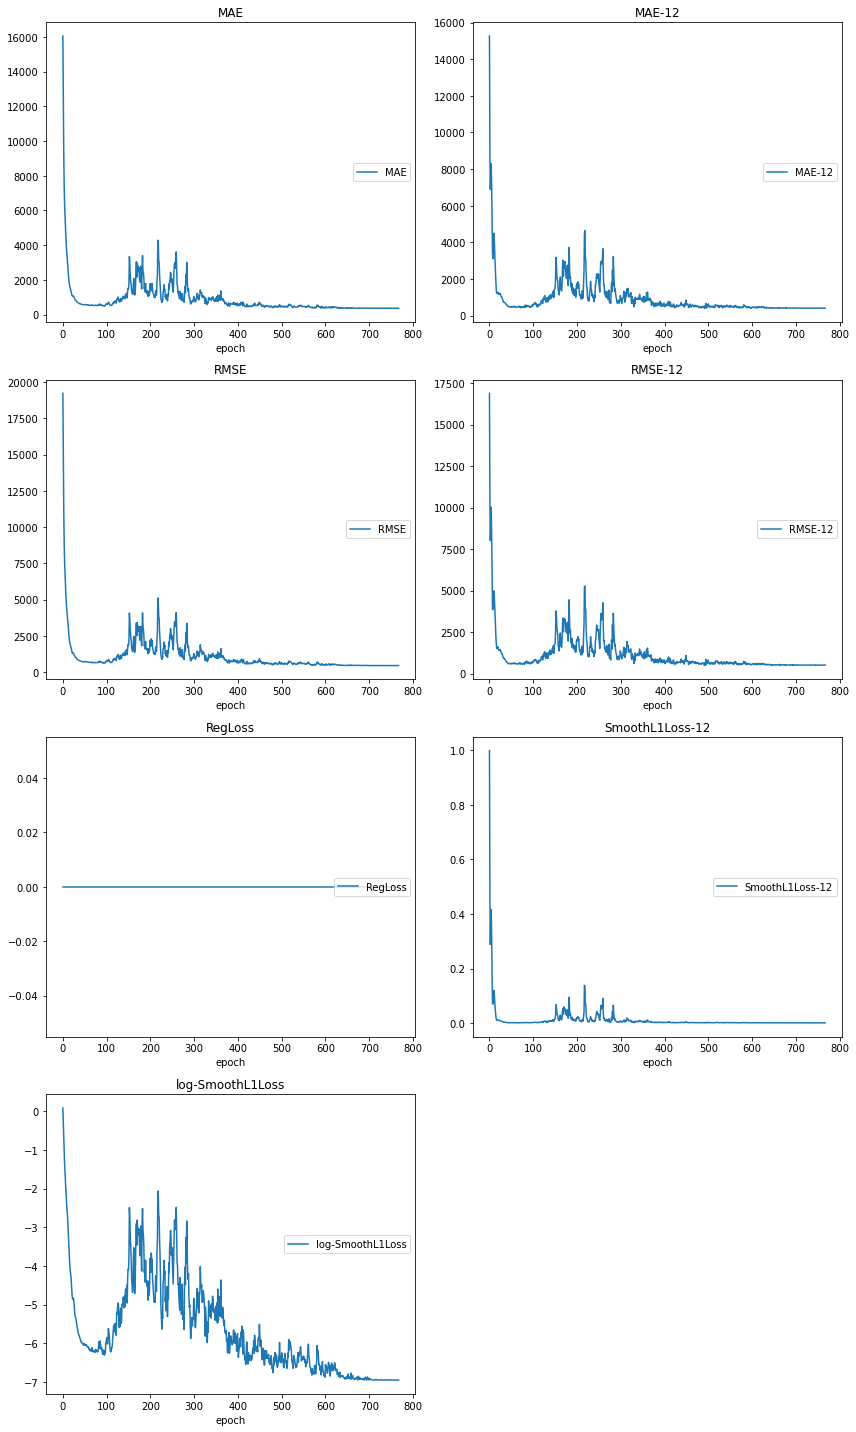

MAE
	MAE              	 (min:  365.051, max: 16049.414, cur:  367.049)
MAE-12
	MAE-12           	 (min:  400.080, max: 15268.010, cur:  407.264)
RMSE
	RMSE             	 (min:  454.369, max: 19221.784, cur:  455.735)
RMSE-12
	RMSE-12          	 (min:  478.122, max: 16879.357, cur:  511.789)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
SmoothL1Loss-12
	SmoothL1Loss-12  	 (min:    0.001, max:    0.998, cur:    0.001)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -6.954, max:    0.085, cur:   -6.950)


In [14]:
m = NeuralProphet(n_changepoints=10,
                  n_forecasts=12,
                  n_lags=6,
                  changepoints_range=0.75,
                  num_hidden_layers=1,
                  d_hidden=16,
                  learning_rate = 1.1
                 )
m = m.highlight_nth_step_ahead_of_each_forecast(12)
metrics = m.fit(df,progress='plot-all')

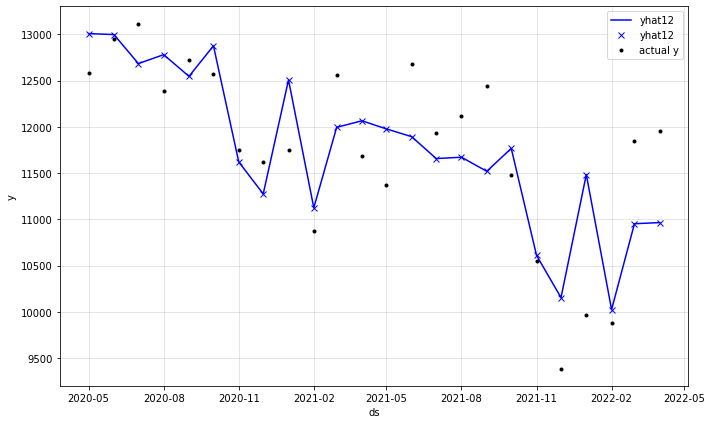

In [15]:
forecast = m.predict(df)
fig1 = m.plot(forecast[-24:])

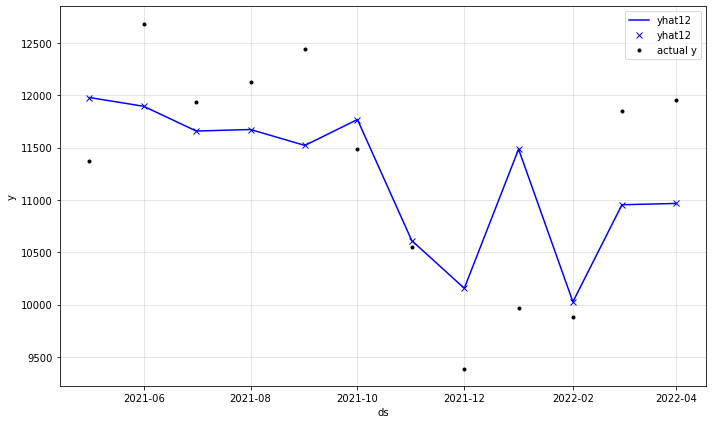

In [16]:
fig2 = m.plot(forecast[-12:])

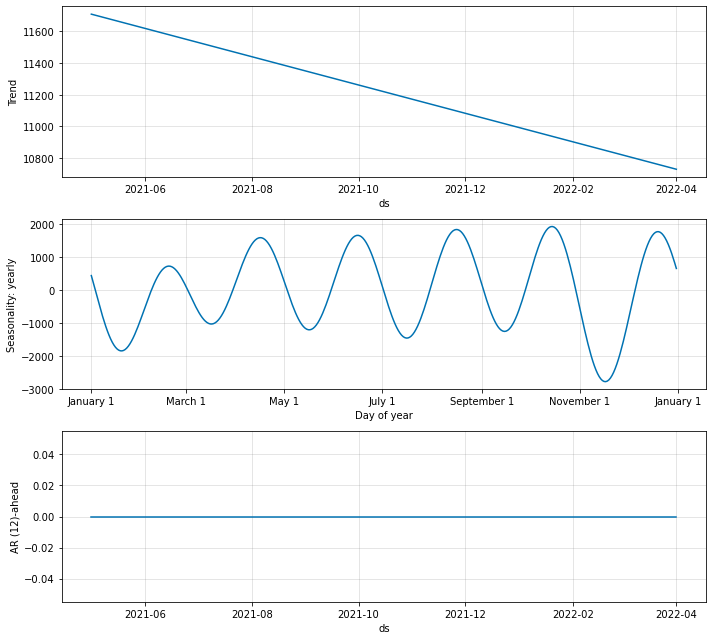

In [17]:
comp = m.plot_components(forecast[-12:])

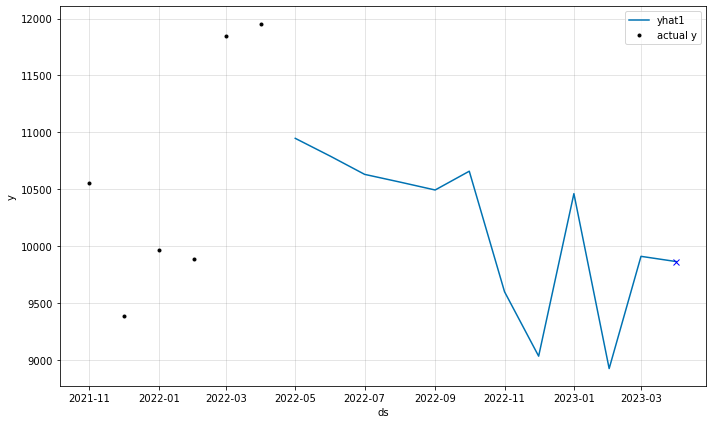

In [18]:
future = m.make_future_dataframe(df, periods=12)
forecast = m.predict(future)
fig = m.plot(forecast)